In [1]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  from google.colab import drive
  drive.mount('/content/drive')
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session9'
  sys.path.append(module_path)
  print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session9']


## Import Modules


In [2]:
# Import necessary library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import math
from collections import OrderedDict

In [3]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Dataset Analysis

## Extract and Load the Data

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


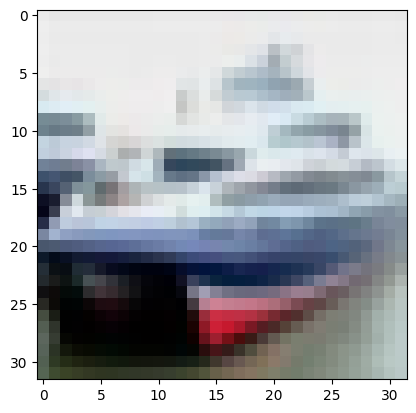

In [5]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Parameters

In [6]:
BATCH_SIZE = 512
EPOCHS = 100
DISPLAY_SAMPLES = 20
LEARNING_RATE = 0.112
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1

## Visualize Training Data

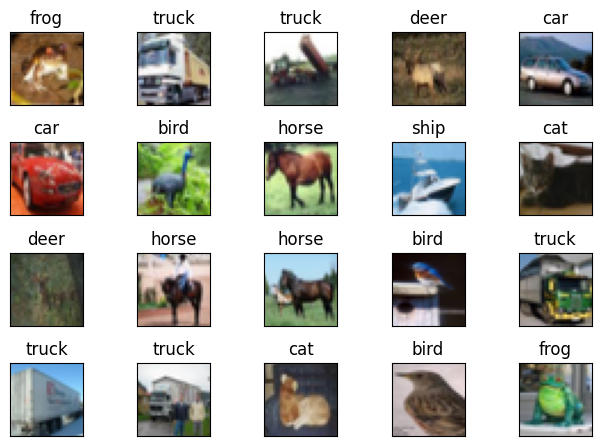

In [7]:
from utils import display_cifar_data_samples

sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

## Transformations

In [8]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=0.2),
    'horizontalflip': A.HorizontalFlip(),
    'rotation': A.Rotate(15),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

## Get Transformed Dataset

In [9]:
from datasets import TransformedDataset

train_set = TransformedDataset('./data', train=True, download=True, transform=train_transforms)
test_set = TransformedDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


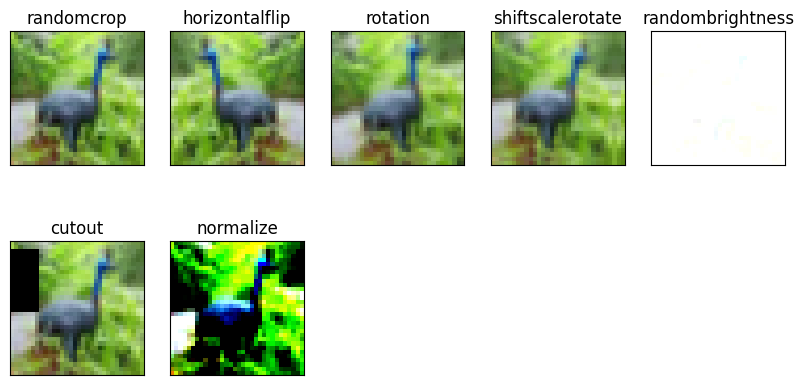

In [10]:
from utils import visualize_cifar_augmentation

aug_train = TransformedDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'rotation': A.Rotate(15, p=1),
    'shiftscalerotate': A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1),
    'randombrightness': A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968, 0.48215827 ,0.44653124], mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [11]:
SEED = 48

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


In [12]:
STEPS_PER_EPOCH =int(len(train_loader)*1)
print(f'STEPS_PER_EPOCH {STEPS_PER_EPOCH}')

STEPS_PER_EPOCH 98


In [13]:
len(train_loader)

98

## Model and its Parameters

In [14]:
from models import Session9Net, get_summary
get_summary(Session9Net(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 15, 15]           9,216
       BatchNorm2d-8           [-1, 32, 15, 15]              64
              ReLU-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 38, 15, 15]          10,944
      BatchNorm2d-11           [-1, 38, 15, 15]              76
             ReLU-12           [-1, 38, 15, 15]               0
           Conv2d-13           [-1, 38, 15, 15]          12,996
      BatchNorm2d-14           [-1, 38,

## Model Training and Testing

In [15]:
from training_utils import train, test

In [16]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [17]:


# Put the model on selected device
model = Session9Net().to(device)

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# New Line
criterion = F.nll_loss

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.8603 Batch_id=97 Accuracy=21.74: 100%|██████████| 98/98 [00:12<00:00,  7.91it/s]


Test set: Average loss: 1.7791, Accuracy: 3318/10000 (33.18%)

Epoch 2


Train: Loss=1.6730 Batch_id=97 Accuracy=35.22: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]


Test set: Average loss: 1.5485, Accuracy: 4322/10000 (43.22%)

Epoch 3


Train: Loss=1.4805 Batch_id=97 Accuracy=42.78: 100%|██████████| 98/98 [00:11<00:00,  8.22it/s]


Test set: Average loss: 1.4320, Accuracy: 4782/10000 (47.82%)

Epoch 4


Train: Loss=1.3464 Batch_id=97 Accuracy=47.03: 100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


Test set: Average loss: 1.3310, Accuracy: 5226/10000 (52.26%)

Epoch 5


Train: Loss=1.2769 Batch_id=97 Accuracy=49.86: 100%|██████████| 98/98 [00:11<00:00,  8.28it/s]


Test set: Average loss: 1.1750, Accuracy: 5774/10000 (57.74%)

Epoch 6


Train: Loss=1.3642 Batch_id=97 Accuracy=52.81: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s]


Test set: Average loss: 1.2338, Accuracy: 5651/10000 (56.51%)

Epoch 7


Train: Loss=1.2112 Batch_id=97 Accuracy=54.84: 100%|██████████| 98/98 [00:11<00:00,  8.73it/s]


Test set: Average loss: 1.0591, Accuracy: 6191/10000 (61.91%)

Epoch 8


Train: Loss=1.1951 Batch_id=97 Accuracy=56.79: 100%|██████████| 98/98 [00:11<00:00,  8.32it/s]


Test set: Average loss: 1.0984, Accuracy: 6171/10000 (61.71%)

Epoch 9


Train: Loss=1.1483 Batch_id=97 Accuracy=58.40: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]


Test set: Average loss: 1.0623, Accuracy: 6314/10000 (63.14%)

Epoch 10


Train: Loss=1.1474 Batch_id=97 Accuracy=60.67: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Test set: Average loss: 0.9642, Accuracy: 6604/10000 (66.04%)

Epoch 11


Train: Loss=0.9899 Batch_id=97 Accuracy=61.74: 100%|██████████| 98/98 [00:11<00:00,  8.26it/s]


Test set: Average loss: 0.9178, Accuracy: 6783/10000 (67.83%)

Epoch 12


Train: Loss=0.9690 Batch_id=97 Accuracy=63.46: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.8764, Accuracy: 6981/10000 (69.81%)

Epoch 13


Train: Loss=0.9341 Batch_id=97 Accuracy=64.80: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Test set: Average loss: 0.9169, Accuracy: 6853/10000 (68.53%)

Epoch 14


Train: Loss=1.0047 Batch_id=97 Accuracy=65.40: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


Test set: Average loss: 0.8550, Accuracy: 7039/10000 (70.39%)

Epoch 15


Train: Loss=0.8812 Batch_id=97 Accuracy=66.44: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]


Test set: Average loss: 0.9476, Accuracy: 6835/10000 (68.35%)

Epoch 16


Train: Loss=0.7933 Batch_id=97 Accuracy=67.38: 100%|██████████| 98/98 [00:11<00:00,  8.54it/s]


Test set: Average loss: 0.8648, Accuracy: 7037/10000 (70.37%)

Epoch 17


Train: Loss=0.9531 Batch_id=97 Accuracy=68.40: 100%|██████████| 98/98 [00:11<00:00,  8.90it/s]


Test set: Average loss: 0.9000, Accuracy: 6942/10000 (69.42%)

Epoch 18


Train: Loss=0.8931 Batch_id=97 Accuracy=69.03: 100%|██████████| 98/98 [00:10<00:00,  8.95it/s]


Test set: Average loss: 0.8258, Accuracy: 7212/10000 (72.12%)

Epoch 19


Train: Loss=0.9521 Batch_id=97 Accuracy=69.39: 100%|██████████| 98/98 [00:11<00:00,  8.45it/s]


Test set: Average loss: 0.7670, Accuracy: 7350/10000 (73.50%)

Epoch 20


Train: Loss=0.7838 Batch_id=97 Accuracy=70.13: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Test set: Average loss: 0.6951, Accuracy: 7601/10000 (76.01%)

Epoch 21


Train: Loss=0.8548 Batch_id=97 Accuracy=70.50: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.6976, Accuracy: 7577/10000 (75.77%)

Epoch 22


Train: Loss=0.7854 Batch_id=97 Accuracy=71.40: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]


Test set: Average loss: 0.7658, Accuracy: 7376/10000 (73.76%)

Epoch 23


Train: Loss=0.8516 Batch_id=97 Accuracy=71.83: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]


Test set: Average loss: 0.8352, Accuracy: 7221/10000 (72.21%)

Epoch 24


Train: Loss=0.8747 Batch_id=97 Accuracy=72.20: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]


Test set: Average loss: 0.8139, Accuracy: 7342/10000 (73.42%)

Epoch 25


Train: Loss=0.7900 Batch_id=97 Accuracy=72.32: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.6575, Accuracy: 7744/10000 (77.44%)

Epoch 26


Train: Loss=0.7793 Batch_id=97 Accuracy=73.03: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]


Test set: Average loss: 0.6281, Accuracy: 7827/10000 (78.27%)

Epoch 27


Train: Loss=0.8191 Batch_id=97 Accuracy=73.04: 100%|██████████| 98/98 [00:11<00:00,  8.34it/s]


Test set: Average loss: 0.7778, Accuracy: 7382/10000 (73.82%)

Epoch 28


Train: Loss=0.7199 Batch_id=97 Accuracy=73.58: 100%|██████████| 98/98 [00:11<00:00,  8.89it/s]


Test set: Average loss: 0.6712, Accuracy: 7725/10000 (77.25%)

Epoch 29


Train: Loss=0.7458 Batch_id=97 Accuracy=74.01: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s]


Test set: Average loss: 0.6919, Accuracy: 7707/10000 (77.07%)

Epoch 30


Train: Loss=0.6552 Batch_id=97 Accuracy=74.35: 100%|██████████| 98/98 [00:11<00:00,  8.84it/s]


Test set: Average loss: 0.6235, Accuracy: 7813/10000 (78.13%)

Epoch 31


Train: Loss=0.6653 Batch_id=97 Accuracy=74.32: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


Test set: Average loss: 0.6629, Accuracy: 7740/10000 (77.40%)

Epoch 32


Train: Loss=0.7601 Batch_id=97 Accuracy=74.24: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


Test set: Average loss: 0.6339, Accuracy: 7828/10000 (78.28%)

Epoch 33


Train: Loss=0.7803 Batch_id=97 Accuracy=74.93: 100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


Test set: Average loss: 0.6395, Accuracy: 7795/10000 (77.95%)

Epoch 34


Train: Loss=0.6105 Batch_id=97 Accuracy=74.93: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


Test set: Average loss: 0.6187, Accuracy: 7903/10000 (79.03%)

Epoch 35


Train: Loss=0.6864 Batch_id=97 Accuracy=75.49: 100%|██████████| 98/98 [00:11<00:00,  8.51it/s]


Test set: Average loss: 0.6007, Accuracy: 7946/10000 (79.46%)

Epoch 36


Train: Loss=0.7570 Batch_id=97 Accuracy=75.41: 100%|██████████| 98/98 [00:11<00:00,  8.72it/s]


Test set: Average loss: 0.5743, Accuracy: 8016/10000 (80.16%)

Epoch 37


Train: Loss=0.6730 Batch_id=97 Accuracy=75.77: 100%|██████████| 98/98 [00:11<00:00,  8.80it/s]


Test set: Average loss: 0.6350, Accuracy: 7876/10000 (78.76%)

Epoch 38


Train: Loss=0.7560 Batch_id=97 Accuracy=76.25: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Test set: Average loss: 0.5827, Accuracy: 8014/10000 (80.14%)

Epoch 39


Train: Loss=0.7345 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:10<00:00,  9.12it/s]


Test set: Average loss: 0.5798, Accuracy: 8033/10000 (80.33%)

Epoch 40


Train: Loss=0.6481 Batch_id=97 Accuracy=76.29: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.6438, Accuracy: 7871/10000 (78.71%)

Epoch 41


Train: Loss=0.5459 Batch_id=97 Accuracy=76.72: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


Test set: Average loss: 0.6158, Accuracy: 7947/10000 (79.47%)

Epoch 42


Train: Loss=0.7300 Batch_id=97 Accuracy=76.80: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]


Test set: Average loss: 0.5504, Accuracy: 8116/10000 (81.16%)

Epoch 43


Train: Loss=0.7492 Batch_id=97 Accuracy=76.68: 100%|██████████| 98/98 [00:12<00:00,  7.83it/s]


Test set: Average loss: 0.6240, Accuracy: 7871/10000 (78.71%)

Epoch 44


Train: Loss=0.7346 Batch_id=97 Accuracy=76.92: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.5574, Accuracy: 8058/10000 (80.58%)

Epoch 45


Train: Loss=0.7191 Batch_id=97 Accuracy=77.13: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]


Test set: Average loss: 0.6322, Accuracy: 7892/10000 (78.92%)

Epoch 46


Train: Loss=0.7357 Batch_id=97 Accuracy=77.25: 100%|██████████| 98/98 [00:11<00:00,  8.62it/s]


Test set: Average loss: 0.5759, Accuracy: 8034/10000 (80.34%)

Epoch 47


Train: Loss=0.6482 Batch_id=97 Accuracy=77.53: 100%|██████████| 98/98 [00:10<00:00,  8.97it/s]


Test set: Average loss: 0.5680, Accuracy: 8030/10000 (80.30%)

Epoch 48


Train: Loss=0.5747 Batch_id=97 Accuracy=77.93: 100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


Test set: Average loss: 0.6129, Accuracy: 7987/10000 (79.87%)

Epoch 49


Train: Loss=0.6893 Batch_id=97 Accuracy=77.49: 100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


Test set: Average loss: 0.5966, Accuracy: 7986/10000 (79.86%)

Epoch 50


Train: Loss=0.5805 Batch_id=97 Accuracy=77.99: 100%|██████████| 98/98 [00:11<00:00,  8.38it/s]


Test set: Average loss: 0.6507, Accuracy: 7842/10000 (78.42%)

Epoch 51


Train: Loss=0.7305 Batch_id=97 Accuracy=78.12: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


Test set: Average loss: 0.5678, Accuracy: 8114/10000 (81.14%)

Epoch 52


Train: Loss=0.6424 Batch_id=97 Accuracy=77.98: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s]


Test set: Average loss: 0.5128, Accuracy: 8269/10000 (82.69%)

Epoch 53


Train: Loss=0.6683 Batch_id=97 Accuracy=78.38: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]


Test set: Average loss: 0.5540, Accuracy: 8120/10000 (81.20%)

Epoch 54


Train: Loss=0.5927 Batch_id=97 Accuracy=78.14: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


Test set: Average loss: 0.5826, Accuracy: 8012/10000 (80.12%)

Epoch 55


Train: Loss=0.5785 Batch_id=97 Accuracy=78.52: 100%|██████████| 98/98 [00:10<00:00,  9.28it/s]


Test set: Average loss: 0.5323, Accuracy: 8190/10000 (81.90%)

Epoch 56


Train: Loss=0.5738 Batch_id=97 Accuracy=78.63: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s]


Test set: Average loss: 0.5241, Accuracy: 8227/10000 (82.27%)

Epoch 57


Train: Loss=0.5868 Batch_id=97 Accuracy=78.75: 100%|██████████| 98/98 [00:10<00:00,  9.01it/s]


Test set: Average loss: 0.5298, Accuracy: 8209/10000 (82.09%)

Epoch 58


Train: Loss=0.6772 Batch_id=97 Accuracy=78.99: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Test set: Average loss: 0.6141, Accuracy: 8001/10000 (80.01%)

Epoch 59


Train: Loss=0.6027 Batch_id=97 Accuracy=79.30: 100%|██████████| 98/98 [00:12<00:00,  7.88it/s]


Test set: Average loss: 0.5230, Accuracy: 8263/10000 (82.63%)

Epoch 60


Train: Loss=0.5792 Batch_id=97 Accuracy=78.95: 100%|██████████| 98/98 [00:12<00:00,  7.99it/s]


Test set: Average loss: 0.5445, Accuracy: 8160/10000 (81.60%)

Epoch 61


Train: Loss=0.6488 Batch_id=97 Accuracy=79.23: 100%|██████████| 98/98 [00:12<00:00,  8.04it/s]


Test set: Average loss: 0.5555, Accuracy: 8130/10000 (81.30%)

Epoch 62


Train: Loss=0.6442 Batch_id=97 Accuracy=79.04: 100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


Test set: Average loss: 0.5154, Accuracy: 8235/10000 (82.35%)

Epoch 63


Train: Loss=0.5362 Batch_id=97 Accuracy=79.44: 100%|██████████| 98/98 [00:11<00:00,  8.32it/s]


Test set: Average loss: 0.5031, Accuracy: 8287/10000 (82.87%)

Epoch 64


Train: Loss=0.6172 Batch_id=97 Accuracy=79.92: 100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


Test set: Average loss: 0.5466, Accuracy: 8182/10000 (81.82%)

Epoch 65


Train: Loss=0.6256 Batch_id=97 Accuracy=79.58: 100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


Test set: Average loss: 0.4838, Accuracy: 8387/10000 (83.87%)

Epoch 66


Train: Loss=0.6167 Batch_id=97 Accuracy=79.82: 100%|██████████| 98/98 [00:11<00:00,  8.59it/s]


Test set: Average loss: 0.5075, Accuracy: 8306/10000 (83.06%)

Epoch 67


Train: Loss=0.5363 Batch_id=97 Accuracy=79.94: 100%|██████████| 98/98 [00:11<00:00,  8.69it/s]


Test set: Average loss: 0.5034, Accuracy: 8257/10000 (82.57%)

Epoch 68


Train: Loss=0.4460 Batch_id=97 Accuracy=80.13: 100%|██████████| 98/98 [00:11<00:00,  8.70it/s]


Test set: Average loss: 0.4866, Accuracy: 8359/10000 (83.59%)

Epoch 69


Train: Loss=0.5400 Batch_id=97 Accuracy=80.16: 100%|██████████| 98/98 [00:12<00:00,  8.05it/s]


Test set: Average loss: 0.5071, Accuracy: 8300/10000 (83.00%)

Epoch 70


Train: Loss=0.5982 Batch_id=97 Accuracy=80.21: 100%|██████████| 98/98 [00:11<00:00,  8.41it/s]


Test set: Average loss: 0.4933, Accuracy: 8364/10000 (83.64%)

Epoch 71


Train: Loss=0.5798 Batch_id=97 Accuracy=80.52: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]


Test set: Average loss: 0.4969, Accuracy: 8330/10000 (83.30%)

Epoch 72


Train: Loss=0.5569 Batch_id=97 Accuracy=80.29: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Test set: Average loss: 0.4749, Accuracy: 8379/10000 (83.79%)

Epoch 73


Train: Loss=0.5865 Batch_id=97 Accuracy=80.92: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]


Test set: Average loss: 0.4859, Accuracy: 8327/10000 (83.27%)

Epoch 74


Train: Loss=0.5381 Batch_id=97 Accuracy=81.17: 100%|██████████| 98/98 [00:11<00:00,  8.53it/s]


Test set: Average loss: 0.4904, Accuracy: 8336/10000 (83.36%)

Epoch 75


Train: Loss=0.5949 Batch_id=97 Accuracy=81.14: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.4823, Accuracy: 8372/10000 (83.72%)

Epoch 76


Train: Loss=0.6351 Batch_id=97 Accuracy=81.25: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


Test set: Average loss: 0.4874, Accuracy: 8367/10000 (83.67%)

Epoch 77


Train: Loss=0.4829 Batch_id=97 Accuracy=81.32: 100%|██████████| 98/98 [00:11<00:00,  8.85it/s]


Test set: Average loss: 0.4674, Accuracy: 8427/10000 (84.27%)

Epoch 78


Train: Loss=0.5191 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:11<00:00,  8.47it/s]


Test set: Average loss: 0.4837, Accuracy: 8376/10000 (83.76%)

Epoch 79


Train: Loss=0.4656 Batch_id=97 Accuracy=81.47: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]


Test set: Average loss: 0.4741, Accuracy: 8423/10000 (84.23%)

Epoch 80


Train: Loss=0.5126 Batch_id=97 Accuracy=81.84: 100%|██████████| 98/98 [00:12<00:00,  7.88it/s]


Test set: Average loss: 0.4524, Accuracy: 8490/10000 (84.90%)

Epoch 81


Train: Loss=0.5443 Batch_id=97 Accuracy=82.10: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]


Test set: Average loss: 0.4580, Accuracy: 8483/10000 (84.83%)

Epoch 82


Train: Loss=0.5283 Batch_id=97 Accuracy=82.19: 100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


Test set: Average loss: 0.4452, Accuracy: 8500/10000 (85.00%)

Epoch 83


Train: Loss=0.4396 Batch_id=97 Accuracy=82.18: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]


Test set: Average loss: 0.4388, Accuracy: 8534/10000 (85.34%)

Epoch 84


Train: Loss=0.4816 Batch_id=97 Accuracy=82.74: 100%|██████████| 98/98 [00:11<00:00,  8.48it/s]


Test set: Average loss: 0.4603, Accuracy: 8413/10000 (84.13%)

Epoch 85


Train: Loss=0.4748 Batch_id=97 Accuracy=82.67: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Test set: Average loss: 0.4463, Accuracy: 8498/10000 (84.98%)

Epoch 86


Train: Loss=0.4582 Batch_id=97 Accuracy=82.72: 100%|██████████| 98/98 [00:10<00:00,  9.14it/s]


Test set: Average loss: 0.4368, Accuracy: 8541/10000 (85.41%)

Epoch 87


Train: Loss=0.4084 Batch_id=97 Accuracy=83.17: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


Test set: Average loss: 0.4325, Accuracy: 8543/10000 (85.43%)

Epoch 88


Train: Loss=0.5330 Batch_id=97 Accuracy=83.16: 100%|██████████| 98/98 [00:11<00:00,  8.41it/s]


Test set: Average loss: 0.4374, Accuracy: 8521/10000 (85.21%)

Epoch 89


Train: Loss=0.4021 Batch_id=97 Accuracy=83.38: 100%|██████████| 98/98 [00:11<00:00,  8.18it/s]


Test set: Average loss: 0.4263, Accuracy: 8553/10000 (85.53%)

Epoch 90


Train: Loss=0.5085 Batch_id=97 Accuracy=83.48: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]


Test set: Average loss: 0.4310, Accuracy: 8538/10000 (85.38%)

Epoch 91


Train: Loss=0.4808 Batch_id=97 Accuracy=83.79: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


Test set: Average loss: 0.4326, Accuracy: 8535/10000 (85.35%)

Epoch 92


Train: Loss=0.4831 Batch_id=97 Accuracy=83.95: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


Test set: Average loss: 0.4258, Accuracy: 8564/10000 (85.64%)

Epoch 93


Train: Loss=0.4839 Batch_id=97 Accuracy=83.96: 100%|██████████| 98/98 [00:11<00:00,  8.55it/s]


Test set: Average loss: 0.4235, Accuracy: 8576/10000 (85.76%)

Epoch 94


Train: Loss=0.4304 Batch_id=97 Accuracy=84.20: 100%|██████████| 98/98 [00:10<00:00,  8.96it/s]


Test set: Average loss: 0.4266, Accuracy: 8554/10000 (85.54%)

Epoch 95


Train: Loss=0.4360 Batch_id=97 Accuracy=83.97: 100%|██████████| 98/98 [00:10<00:00,  9.61it/s]


Test set: Average loss: 0.4224, Accuracy: 8575/10000 (85.75%)

Epoch 96


Train: Loss=0.4286 Batch_id=97 Accuracy=84.07: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s]


Test set: Average loss: 0.4162, Accuracy: 8588/10000 (85.88%)

Epoch 97


Train: Loss=0.4583 Batch_id=97 Accuracy=83.94: 100%|██████████| 98/98 [00:11<00:00,  8.33it/s]


Test set: Average loss: 0.4186, Accuracy: 8597/10000 (85.97%)

Epoch 98


Train: Loss=0.4756 Batch_id=97 Accuracy=84.30: 100%|██████████| 98/98 [00:11<00:00,  8.47it/s]


Test set: Average loss: 0.4164, Accuracy: 8605/10000 (86.05%)

Epoch 99


Train: Loss=0.4645 Batch_id=97 Accuracy=84.15: 100%|██████████| 98/98 [00:11<00:00,  8.48it/s]


Test set: Average loss: 0.4175, Accuracy: 8604/10000 (86.04%)

Epoch 100


Train: Loss=0.5236 Batch_id=97 Accuracy=84.43: 100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


Test set: Average loss: 0.4165, Accuracy: 8603/10000 (86.03%)



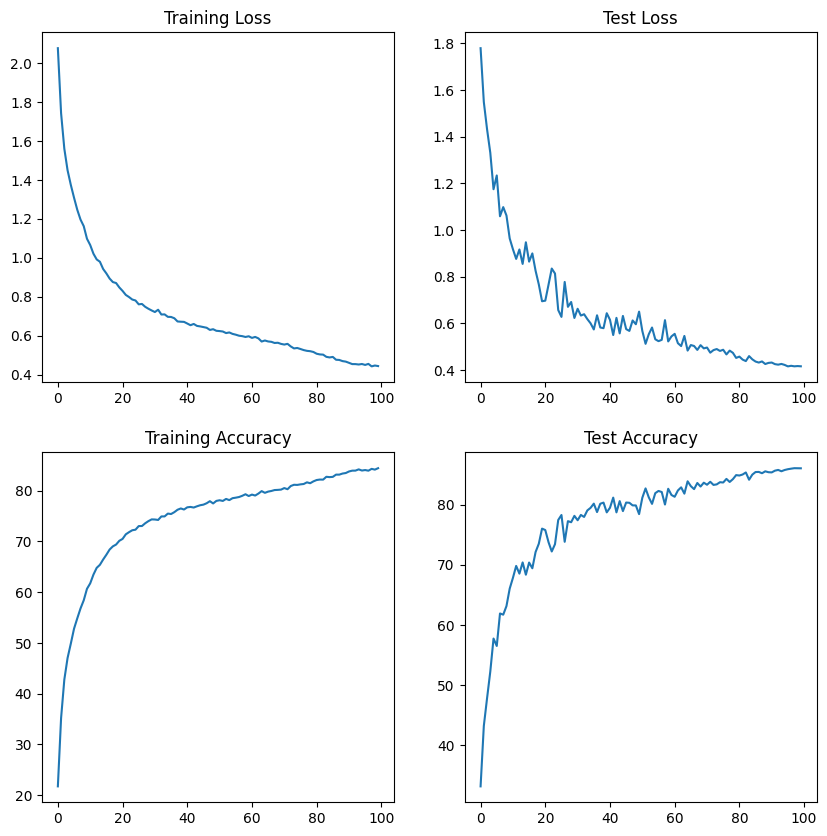

In [18]:
# Print loss and accuracy
from utils import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

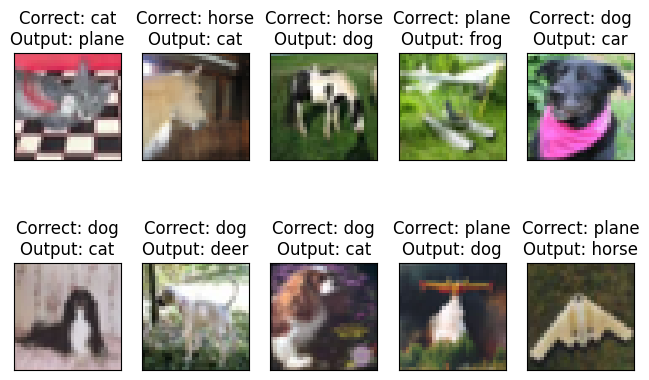

In [19]:
from utils import get_misclassified_data
from utils import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=10)